### Make OpenEO connection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import openeo
from datetime import datetime  

#token SENTINEL
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/").authenticate_oidc()

Authenticated using refresh token.


Load in Cube without METEO


In [3]:
#Get desired data
from preprocessing import worldcereal_preprocessed_inputs

EXTENT = dict(zip(["west", "south", "east", "north"], [664000.0, 5611120.0, 665000.0, 5612120.0]))
EXTENT['crs'] = "EPSG:32631"
EXTENT['srs'] = "EPSG:32631"

STARTDATE = '2020-11-01'
ENDDATE = '2021-10-31'

#TODO aggregator for including METEO?

input_cube = worldcereal_preprocessed_inputs(
     connection = connection,
     bbox = EXTENT,
     start = STARTDATE,
     end = ENDDATE,
     METEO_collection=None,
     S2_collection= "SENTINEL2_L2A",
     S1_collection= "SENTINEL1_GRD",
     DEM_collection= "COPERNICUS_30"
)


## Save preprocessed inputs

Only required if you want to save the intermediate input cube

In [ ]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_input_cube_worldCereal.nc'

input_cube.execute_batch(outputfile = outputfile_name,
                        description='world cereal data collection')

## Run end-to-end inference job


In [4]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_output_worldcereal.nc'

udf = openeo.UDF.from_file("udf_worldcereal_inference.py")

prediction = input_cube.apply_neighborhood(
    process=udf,
    size=[
        {"dimension": "x", "value": 100, "unit": "px"},
        {"dimension": "y", "value": 100, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

prediction = prediction.drop_dimension('t').rename_labels("bands", ["classification"])

prediction.execute_batch(outputfile = outputfile_name,
                        description='world cereal inference',
                        job_options={'driver-memory': '4g',
                                    'executor-memoryOverhead':'8g'} )

0:00:00 Job 'j-240529fb722145acadced18905706e6e': send 'start'
0:00:15 Job 'j-240529fb722145acadced18905706e6e': created (progress 0%)
0:00:20 Job 'j-240529fb722145acadced18905706e6e': created (progress 0%)
0:00:27 Job 'j-240529fb722145acadced18905706e6e': created (progress 0%)
0:00:35 Job 'j-240529fb722145acadced18905706e6e': created (progress 0%)
0:00:45 Job 'j-240529fb722145acadced18905706e6e': created (progress 0%)
0:00:57 Job 'j-240529fb722145acadced18905706e6e': running (progress N/A)
0:01:12 Job 'j-240529fb722145acadced18905706e6e': running (progress N/A)
0:01:32 Job 'j-240529fb722145acadced18905706e6e': running (progress N/A)
0:01:56 Job 'j-240529fb722145acadced18905706e6e': running (progress N/A)
0:02:26 Job 'j-240529fb722145acadced18905706e6e': running (progress N/A)
0:03:04 Job 'j-240529fb722145acadced18905706e6e': running (progress N/A)
0:03:50 Job 'j-240529fb722145acadced18905706e6e': running (progress N/A)
0:04:49 Job 'j-240529fb722145acadced18905706e6e': running (progres

<BatchJob job_id='j-240529fb722145acadced18905706e6e'>

Fetch the output and visualise

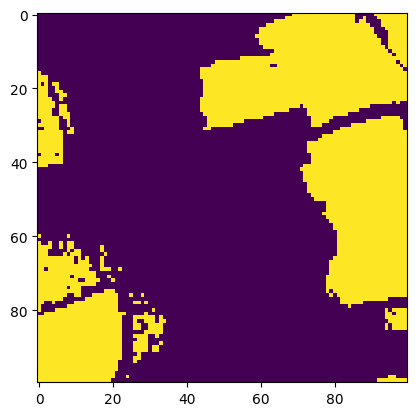

In [5]:
import xarray as xr
import matplotlib.pyplot as plt

output = xr.open_dataset(outputfile_name)
plt.imshow(output['classification'])



## Run the Presto UDF

In [6]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_output_presto.nc'

udf = openeo.UDF.from_file("udf_presto.py")

prediction = input_cube.apply_neighborhood(
    process=udf,
    size=[
        {"dimension": "x", "value": 100, "unit": "px"},
        {"dimension": "y", "value": 100, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

ft_names = [f"presto_ft_{i}" for i in range(128)]
prediction = prediction.drop_dimension('t').rename_labels("bands", ft_names)

prediction.execute_batch(outputfile = outputfile_name,
                        description='world cereal inference',
                        job_options={'driver-memory': '4g',
                                    'executor-memoryOverhead':'8g'} )

0:00:00 Job 'j-240529f3a2b540d583b08b62429bb60b': send 'start'
0:00:14 Job 'j-240529f3a2b540d583b08b62429bb60b': created (progress 0%)
0:00:19 Job 'j-240529f3a2b540d583b08b62429bb60b': created (progress 0%)
0:00:25 Job 'j-240529f3a2b540d583b08b62429bb60b': created (progress 0%)
0:00:34 Job 'j-240529f3a2b540d583b08b62429bb60b': created (progress 0%)
0:00:44 Job 'j-240529f3a2b540d583b08b62429bb60b': created (progress 0%)
0:01:06 Job 'j-240529f3a2b540d583b08b62429bb60b': created (progress 0%)
0:01:23 Job 'j-240529f3a2b540d583b08b62429bb60b': running (progress N/A)
0:01:42 Job 'j-240529f3a2b540d583b08b62429bb60b': running (progress N/A)
0:02:06 Job 'j-240529f3a2b540d583b08b62429bb60b': running (progress N/A)
0:02:36 Job 'j-240529f3a2b540d583b08b62429bb60b': running (progress N/A)
0:03:14 Job 'j-240529f3a2b540d583b08b62429bb60b': running (progress N/A)
0:04:00 Job 'j-240529f3a2b540d583b08b62429bb60b': running (progress N/A)
0:04:59 Job 'j-240529f3a2b540d583b08b62429bb60b': running (progress

<BatchJob job_id='j-240529f3a2b540d583b08b62429bb60b'>

In [11]:
presto = xr.open_dataset(outputfile_name)
print(presto['presto_ft_0'])

<xarray.DataArray 'presto_ft_0' (y: 100, x: 100)> Size: 80kB
[10000 values with dtype=float64]
Coordinates:
  * x        (x) float64 800B 6.64e+05 6.64e+05 6.64e+05 ... 6.65e+05 6.65e+05
  * y        (y) float64 800B 5.612e+06 5.612e+06 ... 5.611e+06 5.611e+06
Attributes:
    long_name:     presto_ft_0
    units:         
    grid_mapping:  crs
